## Abstract

This project investigates the use of supervised machine learning to classify images of chest X-rays into healthy and unhealthy categories. We use deep neural networks in this work. The dataset, ChestMNIST is a cellection of 112,120 grayscale X-ray images. Each X-ray has 28x28 pixels, with binary labels. Healthy is labeled as 0, and unhealthy as 1. This study aims to assist rural areas that do not have access to medical specialist. Furthermore, X-ray is available in number of regions, and this study intends to eliminate the need for future medical imaging that is not available in some areas. Moreover, we hope our work can assist radiologists by automating the classification process, making it faster and more accurate.

Our methodology involves preprocessing the dataset by resizing images, converting multi-label data into binary labels, and addressing class imbalance using under-sampling. Then, a custom convolutional neural network (CNN) architecture is developed. Our proposed model contains three convolutional blocks with increasing filter sizes, dropout regularization, and a final sigmoid activation for binary classification. The model is trained using binary cross-entropy loss and the Adam optimizer. Accuracy, precision, and recall were selected as evaluation metrics.

Our initial results indicate that the CNN model achieves an accuracy of 71.4%, precision of 69.9%, and recall of 74.4%. These results highlight our model's potential. However, possible overfitting and challenges in dataset resolution are also noted. Exploratory data analysis revealed the need for more normalization. Moreover, we believe the model's performance could be further enhanced by employing transfer learning with pretrained models or using higher-resolution datasets.

This work demonstrates the feasibility of using deep learning for medical image classification. We hope it can offer a foundation for future improvements in automated diagnostics and potential integration into clinical studies.

In [18]:

!pip install pyspark medmnist tensorflow findspark scikit-learn matplotlib

In [19]:
# Initialize findspark
import findspark
findspark.init()

In [20]:
# Import necessary libraries
from pyspark.sql import SparkSession
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from medmnist import INFO, ChestMNIST
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import label_binarize

# medmnist is a library that allows us to use medical images. In this case we are using
# chest x-rays of people with pneumonia

In [21]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Final Project Team 19") \
    .getOrCreate()

In [22]:
spark

In [23]:
# Choose chest x-ray data from medmnist library
data_flag = 'chestmnist'
info = INFO[data_flag]

In [24]:
# Load the dataset using MedMNIST library
train_dataset = ChestMNIST(split='train', download=True)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [25]:
X_train = train_dataset.imgs

In [26]:
# ** Data Exploration **
# Methods used below:
#    1) Normalization
#    2) Conversion of multi-label data to binary labels

In [27]:
# Converted multi-label data to binary labels
# We select healthy samples (label 0) and unhealthy samples (with non-zero labels) and reassign all unhealthy samples to label 1.
# To ensure meaningful classification, we prioritize samples with the most frequent labels when selecting unhealthy samples for label 1.

import numpy as np
from sklearn.utils import resample

def create_binary_dataset(X, y, num_samples=25000, random_state=42):

    # Ensure reproducibility
    np.random.seed(random_state)

    # Sum labels per sample to identify samples with label zero
    l_sums = y.sum(axis=1)

    # Samples with label zero (all-zero labels)
    idx_l_z = np.where(l_sums == 0)[0]
    X_l_z = X[idx_l_z]
    y_l_z = y[idx_l_z]

    # Samples with other labels (nonzero label sums)
    idx_l_o = np.where(l_sums > 0)[0]
    X_l_o = X[idx_l_o]
    y_l_o = y[idx_l_o]

    # Determine the frequency of each label in nonzero data
    l_freqs = np.sum(y[idx_l_o], axis=0)
    l_order = np.argsort(l_freqs)[::-1]

    # Collect samples for label 1 based on frequency
    sel_idx = []
    for l_idx in l_order:
      l_spec_idx = idx_l_o[np.where(y[idx_l_o, l_idx] == 1)[0]]
      if len(sel_idx) + len(l_spec_idx) <= num_samples:
        sel_idx.extend(l_spec_idx)
      else:
        rem_samples = num_samples - len(sel_idx)
        sel_idx.extend(l_spec_idx[:rem_samples])
        break

    sel_idx = np.array(sel_idx)
    X_l_1 = X[sel_idx]
    y_l_1 = y[sel_idx]

    # sample randomly class 0 data to match the target size
    X_l_z_sel, y_l_z_sel = resample(
        X_l_z, y_l_z,
        replace=False,
        n_samples=num_samples,
        random_state=random_state
    )

    # Assign binary labels
    y_l_z_bin = np.zeros(len(y_l_z_sel), dtype=int)
    y_l_1_bin = np.ones(len(X_l_1), dtype=int)

    # Combine datasets
    X_bin = np.concatenate((X_l_z_sel, X_l_1), axis=0)
    y_bin = np.concatenate((y_l_z_bin, y_l_1_bin), axis=0)

    # Shuffle the combined dataset
    idx = np.arange(len(y_bin))
    np.random.shuffle(idx)
    X_bin = X_bin[idx]
    y_bin = y_bin[idx]

    return X_bin, y_bin

In [28]:
# Apply the function and crreate the binary dataset
X_train_binary, y_train_binary = create_binary_dataset(X_train, train_dataset.labels, num_samples=25000, random_state=42)

# Verify the sizes
print(f"Number of samples: {len(X_train_binary)}")
print(f"Number of class 0 samples: {np.sum(y_train_binary == 0)}")
print(f"Number of class 1 samples: {np.sum(y_train_binary == 1)}")


Number of samples: 50000
Number of class 0 samples: 25000
Number of class 1 samples: 25000


In [29]:
# Convert to Rdd

binary_rdd = spark.sparkContext.parallelize(zip(X_train_binary, y_train_binary))

In [30]:
from pyspark.ml.linalg import Vectors

In [31]:
# Rdd vectorize

binary_rdd = binary_rdd.map(lambda x: (Vectors.dense(x[0].flatten()), int(x[1])))

In [32]:
# Verify RDD
print(f"Number of samples in RDD: {binary_rdd.count()}")

Number of samples in RDD: 50000


In [47]:
# Convert  to df
binary_df = spark.createDataFrame(binary_rdd, schema=["features", "label"])

binary_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[36.0,30.0,27.0,2...|    1|
|[23.0,1.0,0.0,1.0...|    0|
|[5.0,9.0,26.0,59....|    0|
|[5.0,9.0,10.0,11....|    0|
|[12.0,2.0,2.0,2.0...|    1|
+--------------------+-----+
only showing top 5 rows



In [48]:
binary_df.describe()

DataFrame[summary: string, label: string]

In [49]:
label_counts = binary_df.groupBy("label").count()

label_counts.show()

+-----+-----+
|label|count|
+-----+-----+
|    0|25000|
|    1|25000|
+-----+-----+



In [50]:
binary_df.printSchema()
binary_df.select("features").show(1, truncate=False)

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [37]:
from pyspark.sql.functions import col
from pyspark.ml.linalg import DenseVector

In [38]:
# Convert featuresto a DenseVector
def extract(row):
    if isinstance(row.features, DenseVector):
        return row.features.toArray().tolist()
    else:
        return row.features.values

In [39]:
# Convert features
binary_df = binary_df.rdd.map(lambda r: (r.label, extract(r))).toDF(["label", "features_array"])

In [40]:
# Length of features vector
f_length = len(binary_df.select("features_array").first()[0])

In [41]:
# Column name
co_names = [f"feature_{i}" for i in range(f_length)]

In [42]:
# Split features into columns
for i, name in enumerate(co_names):
    binary_df = binary_df.withColumn(name, col("features_array")[i])

In [43]:
# Drop the original features_array
binary_df = binary_df.drop("features_array")

In [46]:
# Visualize the feature
binary_df.show(1, truncate=False)

+-----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--

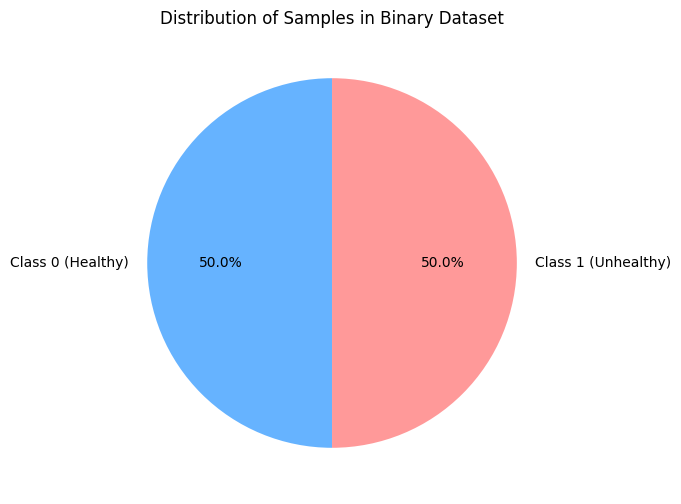

In [15]:
# plot the binary samples

class_counts = [np.sum(y_train_binary == 0), np.sum(y_train_binary == 1)]
labels = ['Class 0 (Healthy)', 'Class 1 (Unhealthy)']

# Plot
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Samples in Binary Dataset')
plt.show()

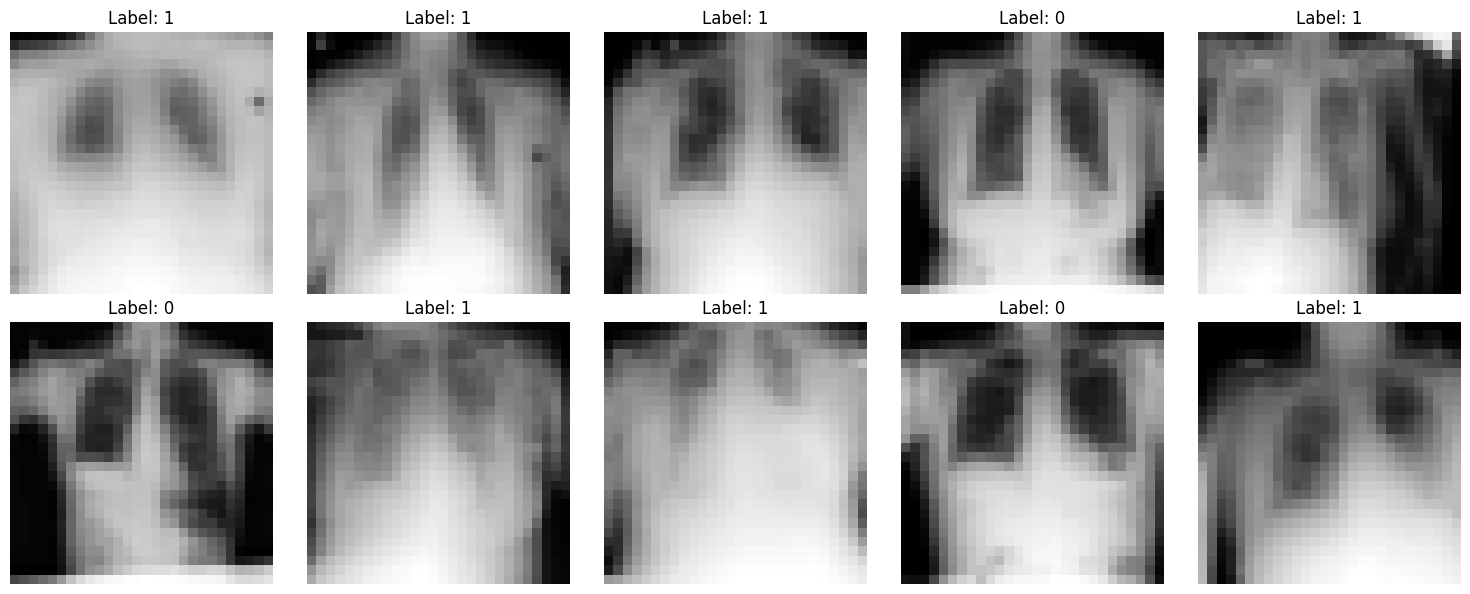

In [16]:
# Randomly show samples

def show_samples(X, y, n_sampl=10):

    # Random:
    ii = np.random.choice(len(X), n_sampl, replace=False)

    rows = n_sampl //5 +(n_sampl%5!=0)
    cols = min(5, n_sampl)

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows*3))
    axes = axes.ravel() if rows >1 else [axes]

    for idx, ax in zip(ii, axes):
        img = X[idx].squeeze()
        label = y[idx]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label}', fontsize=12)
        ax.axis('off')

    for ax in axes[len(ii):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_samples(X_train_binary, y_train_binary, n_sampl=10)


In [25]:
# Split the data into train, test and validation as 80 10 10


from sklearn.model_selection import train_test_split

def split_data(X, y, tr=0.8, val=0.1, ts=0.1, random_state=42):

    assert tr + val + ts == 1, "Must sum to 1."

    # First split: Train + Val and Test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=(val + ts), random_state=random_state
    )

    # Second split: Validation and Test
    val_test_ratio = val / (val + ts)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_test_ratio), random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_train_binary, y_train_binary)

# Print the sizes of each split
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Training set: 40000
Validation set: 5000
Test set: 5000


In [26]:
# Normalize pixel values
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0

In [27]:
# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [28]:
# ** Data Preparation and Feature Engineering **
# Method used below:
#    1) Visualization of data after preprocessing to verify that data is balanced and apply balancing if needed

In [29]:
print(f"Dataset Sizes:")
print(f"Training Set: {len(X_train)}")
print(f"Validation Set: {len(X_val)}")
print(f"Test Set: {len(X_test)}")

Dataset Sizes:
Training Set: 40000
Validation Set: 5000
Test Set: 5000


In [30]:
# Helper function to rebalance the Dataset (under-sampling majority class if needed)

def rebalance_data(X, y):
    X_negative = X[y == 0]
    y_negative = y[y == 0]
    X_positive = X[y == 1]
    y_positive = y[y == 1]

    # Under-sample majority class
    if len(y_negative) > len(y_positive):
        X_majority = X_negative
        y_majority = y_negative
        X_minority = X_positive
        y_minority = y_positive
    else:
        X_majority = X_positive
        y_majority = y_positive
        X_minority = X_negative
        y_minority = y_negative

    X_majority_undersampled, y_majority_undersampled = resample(
        X_majority, y_majority,
        replace=False,
        n_samples=len(y_minority),
        random_state=42
    )

    # Combine the under-sampled majority and minority samples
    X_balanced = np.vstack((X_majority_undersampled, X_minority))
    y_balanced = np.hstack((y_majority_undersampled, y_minority))

    # Shuffle the dataset
    indices = np.arange(len(y_balanced))
    np.random.seed(42)
    np.random.shuffle(indices)

    return X_balanced[indices], y_balanced[indices]


In [31]:
# Apply hepler function to rebalance training data
X_train_balanced, y_train_balanced = rebalance_data(X_train, y_train)

In [32]:
print(f"Dataset Sizes:")
print(f"Training Set: {len(X_train)}")
print(f"Validation Set: {len(X_val)}")
print(f"Test Set: {len(X_test)}")

Dataset Sizes:
Training Set: 40000
Validation Set: 5000
Test Set: 5000


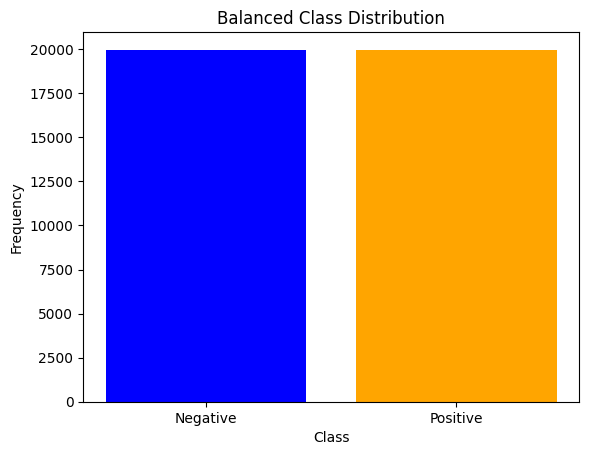

In [33]:
# Visualize Class Distribution
def plot_class_distribution(labels, title="Class Distribution"):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color=['blue', 'orange'])
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(unique, ['Negative', 'Positive'])
    plt.show()

plot_class_distribution(y_train_balanced, title="Balanced Class Distribution")

In [34]:
# ** Machine Learning Prep and Tuning
# Methods used below:
#    1) CNN model build

In [35]:
# Define the CNN model using Keras
# Three convolutional layers with ReLU activation functions
# Dimensionality reduction using MaxPooling
# Stabilization using BatchNormalization
# Overfitting prevention using Dropout
# Regularization with L2
# Flatten layer
# Dense layers for final classification.
# Binary classification using Sigmoid activation (healthy vs. unhealthy).
# Compiled with binary crossentropy loss. optimized for binary classification tasks, precision and recall metrics.

In [36]:
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.02)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 13, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 5, 5, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 1, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,641 (158.75 KB)

 Trainable params: 40,417 (157.88 KB)

 Non-trainable params: 224 (896.00 B)

In [38]:
# We also experimented with Data Augmentation.
# But the accuracy improvement was not significant enough to justify the additional computational cost.

In [39]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data_aug = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True
# )

# # Train with augmented data
# history = model.fit(data_aug.flow(X_train, y_train, batch_size=64), validation_data=(X_val, y_val), epochs=500)


In [40]:
# Train the Model using Keras on 100 epochs to find optimum model. We are using batch sized of 32
history = model.fit(X_train_balanced, y_train_balanced, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.6575 - loss: 1.1219 - precision: 0.6615 - recall: 0.6419 - val_accuracy: 0.6826 - val_loss: 0.6306 - val_precision: 0.6609 - val_recall: 0.7395
Epoch 2/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.6889 - loss: 0.6165 - precision: 0.7032 - recall: 0.6539 - val_accuracy: 0.6780 - val_loss: 0.6413 - val_precision: 0.6491 - val_recall: 0.7637
Epoch 3/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6869 - loss: 0.6111 - precision: 0.6966 - recall: 0.6622 - val_accuracy: 0.5718 - val_loss: 0.6963 - val_precision: 0.5392 - val_recall: 0.9407
Epoch 4/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.6936 - loss: 0.6058 - precision: 0.7010 - recall: 0.6739 - val_accuracy: 0.6918 - val_loss: 0.6048 - val_precision: 0.6677 - val_recall: 0.7536
Epoch 5/100
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.6966 - loss: 0.5998 - precision: 0.7045 - recall: 0.6742 - val_accura

In [41]:
# Model Evaluation and Visualization:
# Methods used:
#    1) Confusion Matrix
#    2) Classfication Report
#    3) Training history visualization

In [42]:
# Evaluate the Model
print(f"Test Loss, Accuracy, Precision, and Recall, respectively: {model.evaluate(X_test, y_test, verbose=0)}")

Test Loss, Accuracy, Precision, and Recall, respectively: [0.7883920669555664, 0.6693999767303467, 0.662282407283783, 0.6869983673095703]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


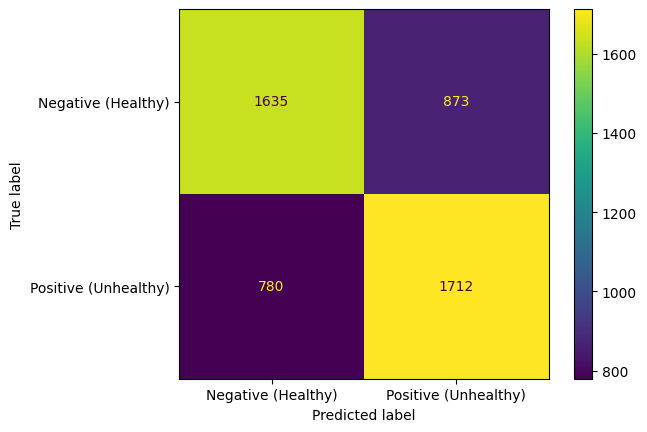

In [43]:
# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary, display_labels=['Negative (Healthy)', 'Positive (Unhealthy)'])
plt.show()

In [44]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.68      0.65      0.66      2508
    Positive       0.66      0.69      0.67      2492

    accuracy                           0.67      5000
   macro avg       0.67      0.67      0.67      5000
weighted avg       0.67      0.67      0.67      5000



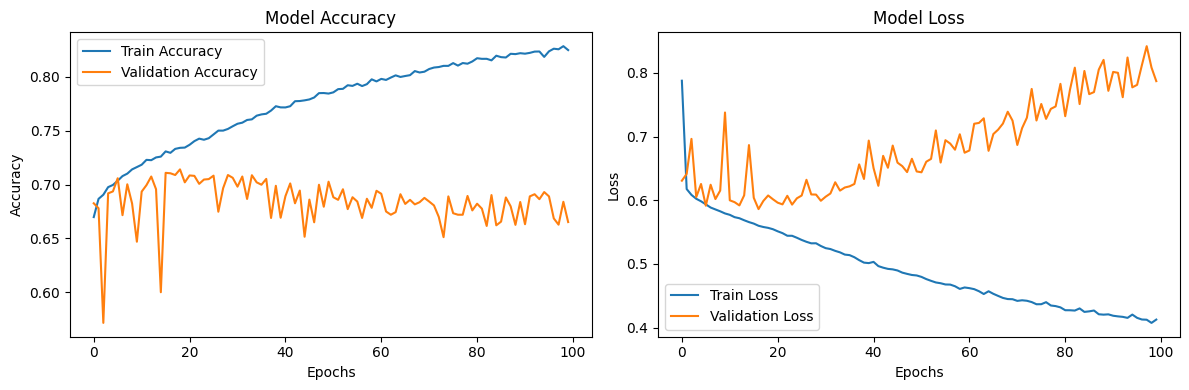

In [45]:
# Plot accuracy and loss over the epochs to view models performane through time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
# Best results at epoch 18

In [59]:
from tensorflow.keras.regularizers import l2

model_o = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.02)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_o.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [60]:
# Train the Model using Keras on 18 epochs to find optimum model. We are using batch sized of 32
history_o = model_o.fit(X_train_balanced, y_train_balanced, epochs=18, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/18
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.6513 - loss: 1.1208 - precision_2: 0.6550 - recall_2: 0.6334 - val_accuracy: 0.6592 - val_loss: 0.6398 - val_precision_2: 0.7377 - val_recall_2: 0.4855
Epoch 2/18
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.6880 - loss: 0.6162 - precision_2: 0.6978 - recall_2: 0.6627 - val_accuracy: 0.6738 - val_loss: 0.6229 - val_precision_2: 0.6458 - val_recall_2: 0.7581
Epoch 3/18
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6971 - loss: 0.6030 - precision_2: 0.7094 - recall_2: 0.6726 - val_accuracy: 0.6984 - val_loss: 0.5997 - val_precision_2: 0.7065 - val_recall_2: 0.6706
Epoch 4/18
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.6982 - loss: 0.5985 - precision_2: 0.7076 - recall_2: 0.6774 - val_accuracy: 0.6138 - val_loss: 0.6718 - val_precision_2: 0.5713 - val_recall_2: 0.8867
Epoch 5/18
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.7035 - loss: 0.5942 - precision_2: 0.7125 

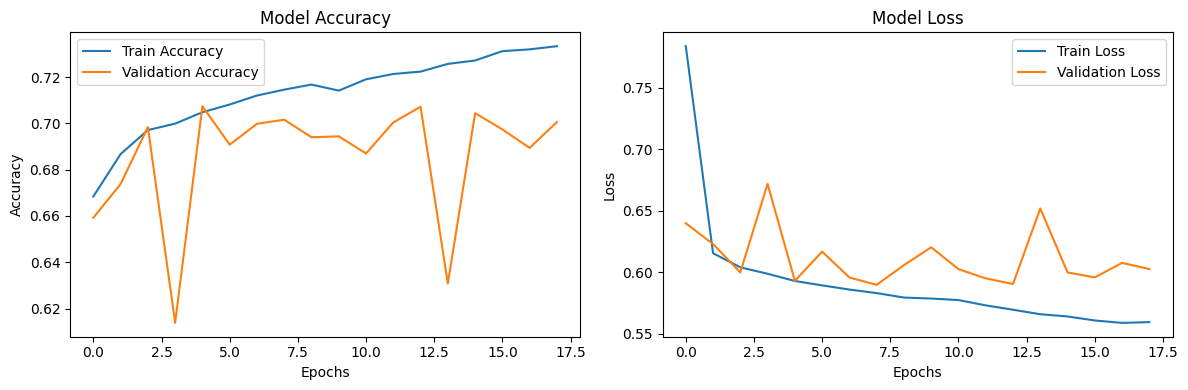

In [64]:
# Plot accuracy and loss over the epochs to view models performane through time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_o.history['accuracy'], label='Train Accuracy')
plt.plot(history_o.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_o.history['loss'], label='Train Loss')
plt.plot(history_o.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
# Evaluate the Model
print(f"Test Loss, Accuracy, Precision, and Recall, respectively: {model_o.evaluate(X_test, y_test, verbose=0)}")

Test Loss, Accuracy, Precision, and Recall, respectively: [0.6021338105201721, 0.7027999758720398, 0.7555894255638123, 0.5967094898223877]


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


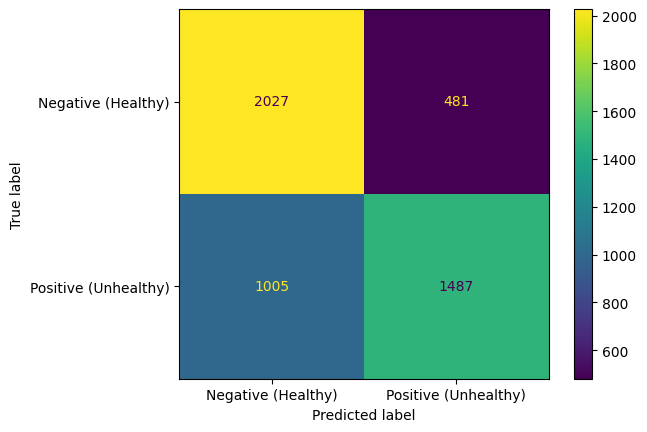

In [66]:
# Confusion Matrix
y_pred = model_o.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary, display_labels=['Negative (Healthy)', 'Positive (Unhealthy)'])
plt.show()

In [67]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary, target_names=['Negative', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.81      0.73      2508
    Positive       0.76      0.60      0.67      2492

    accuracy                           0.70      5000
   macro avg       0.71      0.70      0.70      5000
weighted avg       0.71      0.70      0.70      5000



In [68]:
# Limitations, Future Work, and Conclusion
# Limitations:
#     1) The class balance even after over-sampling may still have been severly imbalanced
#     2) The quality and resolution of the images may not have been fine-grained enough
#     3) Real world diagnosis are more complex than binary classifications

# Future Work:
#     1) Use multi-class classification instead of binary
#     2) increase image resolution for better feature extraction.


In [69]:
# Overall Performance
# The CNN model was able to classify these chest x-ray images with decent accuracy but there are still areas for improvement
# We included the appropriate preprocessing steps, model tuning and evaluation

# We tried multiple approaches and tuning abilites. This is our final approach with the best accuracy we could get.